In [1]:
import pandas as pd
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.utils import to_categorical, plot_model

## a) Generation of the data

In [2]:
def generateDataset(size =10, bars='horizontal'):
  ''' use  bars='horizontal' to generate random horizontal bars
    and  bars='vertical' to generate random vertical bars
  '''
  data = []
  for i in range(size):
    dataset = np.random.random((50, 50)) * 128
    for j in range(10):
      rand_row = np.random.choice(40)
      rand_col = np.random.choice(40)
      if bars=='horizontal':
        dataset[rand_row, rand_col:rand_col+10] = np.full(10, 255.0)
      elif bars=='vertical':
        dataset[rand_row:rand_row+10, rand_col] = np.full(10, 255.0)
    
    data.append(dataset)
  data = np.array(data)
  return data

def plot_gallery(data, shape, labels=None, interpolation='nearest'):
    for i in range(data.shape[0]):
        plt.subplot(1, data.shape[0], (i + 1))
        plt.imshow(data[i].reshape(shape), interpolation=interpolation, cmap="gray")
        if labels != None: 
          plt.title(labels[i])
        plt.xticks(()), plt.yticks(())


In [3]:
data_size = 1000;
X_v_edge_train = generateDataset(size = int(data_size/2), bars='vertical')
X_h_edge_train = generateDataset(size = int(data_size/2), bars='horizontal')

X_v_edge_test = generateDataset(size = int(data_size/2), bars='vertical')
X_h_edge_test = generateDataset(size = int(data_size/2), bars='horizontal')

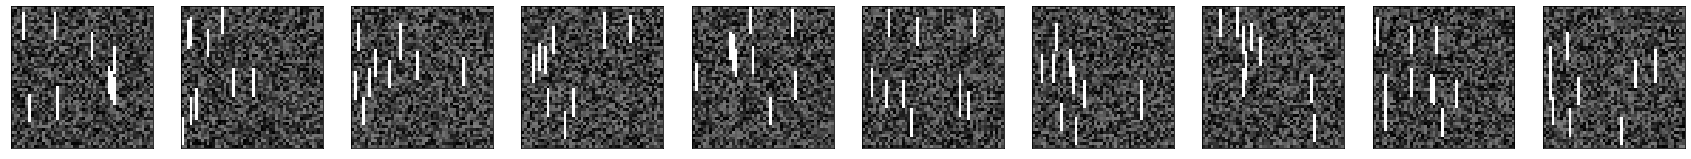

In [4]:
plt.rcParams['figure.figsize'] = 30, 30
plot_gallery(X_v_edge_train[0:10], shape=(50, 50))

Shape of training Data:  (1000, 50, 50, 1)
Shape of test Data:  (1000, 50, 50, 1)


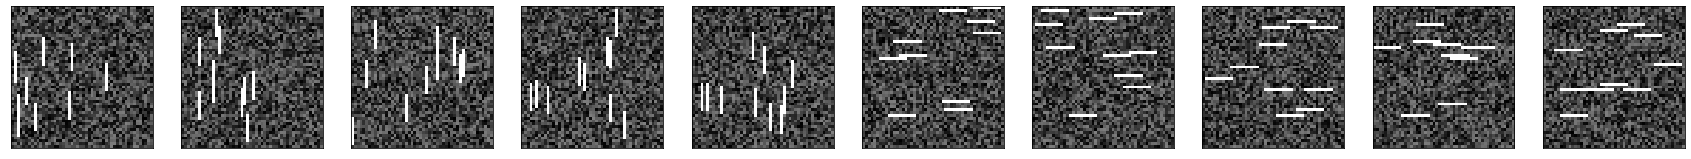

In [5]:
X_training_data = np.concatenate((X_v_edge_train, X_h_edge_train), axis=0)
Y_training_data = np.concatenate((np.zeros(int(data_size/2)), np.ones(int(data_size/2)))) # vertical => y=0 ||| horizontal => y=1

X_test_data = np.concatenate((X_v_edge_test, X_h_edge_test), axis=0)
Y_test_data = np.concatenate((np.zeros(int(data_size/2)), np.ones(int(data_size/2)))) 

# Normalize the images. ==>  -0.5 < x < 0.5
X_training_data = (X_training_data / 255) - 0.5
X_test_data = (X_test_data / 255) - 0.5

# Reshape the images.
X_training_data = np.expand_dims(X_training_data, axis=3)
X_test_data = np.expand_dims(X_test_data, axis=3)

Y_training_data = to_categorical(Y_training_data, num_classes=2)
Y_test_data = to_categorical(Y_test_data, num_classes=2)

print("Shape of training Data: ", X_training_data.shape) # (1000, 50, 50, 1)
print("Shape of test Data: ", X_test_data.shape)  # (1000, 50, 50, 1)

#X_training_data = np.random.permutation(X_training_data)
plot_gallery(X_training_data[495:505], shape=(50, 50))

## b) Build the simplest possible CNN

In [6]:
#create model
model = Sequential()

#add model layers
model.add(Conv2D(1, kernel_size=5, activation='relu', input_shape=(50,50,1), name="conv2d")) # 1 Kernal, with dim 5x5, (50,50,1) for greyscale
#  Not using any padding (“valid” padding) => dim 50x50 ---to---> dim 46x46x1  ! The last dim (1) is the number of kernels (depth)
model.add(MaxPooling2D(pool_size=2)) # dim 46x46x1 ---to---> dim 23x23x1 
model.add(Flatten()) # We flatten() the input to make it easier to work with, since we no longer need its shape. 23x23 = 529
model.add(Dense(2, activation='softmax')) #  fully-connected Output layer with 2 ouput for y=0 and y=1

#compile model using accuracy to measure model performance
# binary_crossentropy (2 classes) and categorical_crossentropy (>2 classes)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

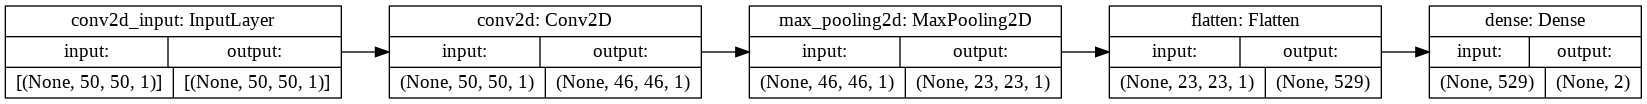

In [7]:
plot_model(model, show_shapes=True, rankdir="LR")

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 1)         26        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 1)         0         
_________________________________________________________________
flatten (Flatten)            (None, 529)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1060      
Total params: 1,086
Trainable params: 1,086
Non-trainable params: 0
_________________________________________________________________


In [9]:
#train the model
callbacks = [keras.callbacks.ModelCheckpoint("cnn.h5", save_best_only=True)]

history = model.fit(X_training_data, Y_training_data, epochs=15, validation_data=(X_test_data, Y_test_data), callbacks=callbacks)

model = keras.models.load_model("cnn.h5")

Epoch 1/15
32/32 [==============================] - 7s 17ms/step - loss: 0.7247 - accuracy: 0.5428 - val_loss: 0.7067 - val_accuracy: 0.5240
Epoch 2/15
32/32 [==============================] - 0s 5ms/step - loss: 0.6980 - accuracy: 0.5033 - val_loss: 0.6813 - val_accuracy: 0.6020
Epoch 3/15
32/32 [==============================] - 0s 5ms/step - loss: 0.6731 - accuracy: 0.5677 - val_loss: 0.6680 - val_accuracy: 0.6100
Epoch 4/15
32/32 [==============================] - 0s 6ms/step - loss: 0.6623 - accuracy: 0.6554 - val_loss: 0.6506 - val_accuracy: 0.6680
Epoch 5/15
32/32 [==============================] - 0s 5ms/step - loss: 0.6414 - accuracy: 0.7320 - val_loss: 0.6249 - val_accuracy: 0.5790
Epoch 6/15
32/32 [==============================] - 0s 5ms/step - loss: 0.6143 - accuracy: 0.6206 - val_loss: 0.5904 - val_accuracy: 0.7120
Epoch 7/15
32/32 [==============================] - 0s 5ms/step - loss: 0.5695 - accuracy: 0.7666 - val_loss: 0.5494 - val_accuracy: 0.7940
Epoch 8/15
32/32 [=

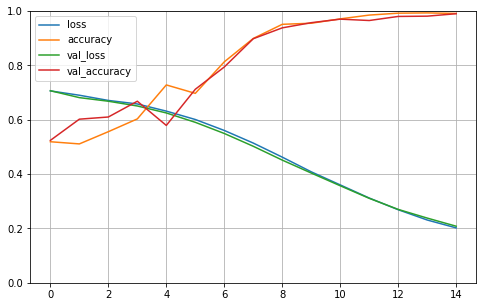

In [10]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [11]:
model.evaluate(X_test_data, Y_test_data)

32/32 [==============================] - 0s 2ms/step - loss: 0.2082 - accuracy: 0.9900


[0.2081674188375473, 0.9900000095367432]

## c) Visualize the learned kernel

In [12]:
weights, bias = model.get_layer("conv2d").get_weights()

weights = (weights - weights.min()) / (weights.max() - weights.min()) # Normalize
weights[0]

array([[[0.2046504 ]],

       [[0.715996  ]],

       [[0.43506378]],

       [[0.20063175]],

       [[0.13997144]]], dtype=float32)

In [13]:
kernel = weights.flatten().reshape(5, -1)
kernel

array([[0.2046504 , 0.715996  , 0.43506378, 0.20063175, 0.13997144],
       [0.07468951, 0.988823  , 0.45309904, 0.06668317, 0.05188294],
       [0.12825924, 0.85108393, 0.41449973, 0.20644021, 0.05840416],
       [0.0674409 , 0.7232585 , 0.65721655, 0.        , 0.2568199 ],
       [0.0566515 , 1.        , 0.58872634, 0.00937152, 0.16460697]],
      dtype=float32)

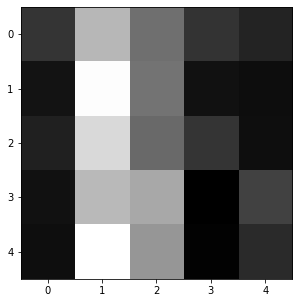

In [14]:
plt.rcParams["figure.figsize"] = [10, 5]

plt.imshow(kernel, cmap='gray', vmin=0, vmax=1)
plt.show()